# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


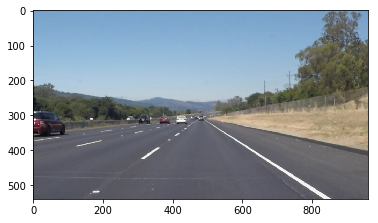

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
x_max = image.shape[1]
y_max = image.shape[0]
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

I made some additions to the code provided. In particular, I added a Queue class that will allow me to define a global variable containing left line, right line pairs. This will be used to compute average lines between frames, thus providing some form of time-dampening. I found that without this addition, the lines drawn by the pipeline are jitter quite a lot.

In [3]:
# Implement a queue class to store latest n lines. It works FILO:
class Queue:
    def __init__(self):
        self.items = []
        
    def isEmpty(self):
        return self.items == []
    
    def enqueue(self, item):
        ''' 
        Adds an element to the queue (with index 0). Each element must be a
        (2 x 1 x 4) numpy array, where item[0, :, :] represents a left line
        and item[1, :, :] a right line.
        '''
        if (type(item) == np.ndarray) & (item.shape == (2, 1, 4)):
            self.items.insert(0, item)
        else:
            print("Wrong dimensions or type, item NOT enqueued")
    
    def dequeue(self):
        '''
        Removes the oldest element from the queue
        '''
        self.items.pop()
        
    def size(self):
        return len(self.items)
    
    def mean(self, left_right):  
        '''
        left_right: 0 for a left line, 1 for a right line
        Returns the mean of the x0, y0, x1 and y1 of all left or right 
        lines in the queue
        '''
        return [np.mean([item[left_right, 0, 0] for item in self.items]),
                np.mean([item[left_right, 0, 1] for item in self.items]),
                np.mean([item[left_right, 0, 2] for item in self.items]),
                np.mean([item[left_right, 0, 3] for item in self.items])]
    def median(self, left_right):
        '''
        left_right: 0 for a left line, 1 for a right line
        Returns the median of the x0, y0, x1 and y1 of all left or right 
        lines in the queue
        '''
        return [np.median([item[left_right, 0, 0] for item in self.items]),
                np.median([item[left_right, 0, 1] for item in self.items]),
                np.median([item[left_right, 0, 2] for item in self.items]),
                np.median([item[left_right, 0, 3] for item in self.items])]

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold, L2gradient):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold, L2gradient = L2gradient)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn and a collection of lines.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if lines != None:
        draw_lines(line_img, lines)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ) 

def extend_lines(img, lines, angle = np.pi / 4, angle_thresh = np.pi / 8, line_avg_num = 5):
    '''
    Draws extended lines on the original image. This function first filters and categorises all 
    the lines found by the Hough transform into left and right lines, based on their slopes.
    It then calculates the medians of the slopes and intercepts of all left (right) lines and 
    uses these values to create a median left (right) line.
    This line's vertices are then averaged with the vertices of the lines contained in the 
    global Queue, which can contain up to `line_avg_num` left/right line pairs. This enables
    temporal dampening and avoids jittery lines (to disable, set `line_avg_num = 1`).
    The resulting average line is then combined to (drawn on) the original image.
    
    Returns the combined image.
    
    Args:
    - img: Should be the original image used for lane line detection
    - lines: The second output of hough_lines; a collection of line-end vertices    
    - angle: Approximate angle (in radians) that left lines are expected to form 
    with the horizontal. For right lines, the function uses pi - angle (assumed
    symetry).
    - angle_thresh: Used to filter out lines whose angle to the horizontal is too
    far from either angle or pi - angle (in radian). Only left lines (resp. right lines)
    within angle +/- angle_thresh (resp. pi - angle +/- angle_thresh) are retained. 
    Recommended values are between 3° and 10°.
    - line_avg_num: Number of lines to average on, as computed from previous frames. The

    '''
    
    left_lines = list()
    right_lines = list()
    middles_left = list()
    middles_right = list()
    slopes_left = list()
    slopes_right = list()
    y_min_left = img.shape[0]
    y_min_right = img.shape[0]
    
    if lines == None:  # If no lines were found during the Hough transform, use latest line in queue
        lines = LINES_Q.items[LINES_Q.size() - 1]
        
    ## Collect left and right lines into separate lists based on slope
    for line in lines:  
        slope = (line[0, 3] - line[0, 1]) / (line[0, 2] - line[0, 0])
        
        # Filter and classify lines as left or right based on their slope:
        if (np.tan(np. pi - angle - angle_thresh)) < slope < (np.tan(np.pi - angle + angle_thresh)):
            # Slope corresponds to a left line:
            left_lines.append(line)      # Add line to our collection of left lines
            slopes_left.append(slope)    # Also collect slopes of left lines
            # And find the minimum y coordinate of left line vertices (which will become one end of 
            # the median computed line):
            if min((line[0, 3], line[0, 1])) < y_min_left:  
                y_min_left = min((line[0, 3], line[0, 1]))  
        
        elif (np.tan(angle - angle_thresh)) < slope < (np.tan(angle + angle_thresh)):
            # Slope corresponds to a right line:
            right_lines.append(line)     # Same for right lanes
            slopes_right.append(slope)   # and their slopes
            if min((line[0, 3], line[0, 1])) < y_min_right:  # and their min y values
                y_min_right = min((line[0, 3], line[0, 1])) 
    
    ## Calculate middle positions of left and right lines
    for line in left_lines:
        middles_left.append(
            (min(line[0, 2], line[0, 0]) + np.abs(line[0, 2] - line[0, 0]) / 2,
             min(line[0, 3], line[0, 1]) + np.abs(line[0, 3] - line[0, 1]) / 2))
    for line in right_lines:
        middles_right.append(
            (min(line[0, 2], line[0, 0]) + np.abs(line[0, 2] - line[0, 0]) / 2,
             min(line[0, 3], line[0, 1]) + np.abs(line[0, 3] - line[0, 1]) / 2))
    
    ## Convert to np.array and calculate medians of middle positions (less sensitive to outliers
    ## than the mean):
    middles_left = np.array(middles_left)
    middles_right = np.array(middles_right)
    median_left = np.zeros(2)
    median_right = np.zeros(2)
    for j in range(2):
        median_left[j] = np.median(middles_left[:, j])
        median_right[j] = np.median(middles_right[:, j])
    
    ## Calculate parameters of the left and right average lines:
    slopes_left = np.array(slopes_left)
    slopes_right = np.array(slopes_right)
    slope_left = np.median(slopes_left)  # Slopes are filtered by value so mean and median are close
    slope_right = np.median(slopes_right)
    intercept_left = median_left[1] - slope_left * median_left[0]
    intercept_right = median_right[1] - slope_right * median_right[0]    

    ## Define end vertices of both lines:
    temp_lines = np.array([[
        [0, intercept_left,  # (x1, y1) for left line
        (y_min_left - intercept_left) / slope_left, y_min_left]],  # (x2, y2) for left line
        [[img.shape[1], img.shape[1] * slope_right + intercept_right,  # (x1, y1) for right line
        (y_min_right - intercept_right) / slope_right, y_min_right  # (x2, y2) for right line
          ]]], np.int32)

    ## Average with previous `line_avg_num` lines:
    LINES_Q.enqueue(temp_lines)
    if LINES_Q.size() > line_avg_num:
        LINES_Q.dequeue()  # Ensure LINE_Q does not exceed its allowed size       
    avg_lines = np.array([[LINES_Q.mean(0)], [LINES_Q.mean(1)]], dtype = np.float32).round()

    ## Create the combined image:
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, avg_lines, color=[255, 0, 0], thickness = 10)
    combined_image = weighted_img(line_img, img, α = 1., β= 0.7, λ=0.)

    return combined_image


##### Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [29]:
import os
files = os.listdir("test_images/")

run your solution on all test_images and make copies into the test_images directory).

In [27]:
def initialize_queue(x_max, y_max, vertex_ratio_h, vertex_ratio_v, angle):
    '''
    Initializes a Queue variable and pre-fills it with theoretical line positions
    '''
    lines_queue = Queue()# Initialise global Queue variable

    # Use the parameters set up above to define a default pair of lines that will be 
    # enqueued in LINES_Q. This prevents crashes in case the Hough transform cannot find
    # any left- or right-hand line on the very first image:
    default_lines = np.array(np.round([
        [[x_max * vertex_ratio_h + y_max*(1-vertex_ratio_v) / np.tan(np.pi - angle),  # Left x0
            y_max,  # Left y0
            x_max * vertex_ratio_h,  # Left x1
            y_max * vertex_ratio_v]],  # Left y1  
        [[x_max*(1-vertex_ratio_h) + y_max*(1-vertex_ratio_v) / np.tan(angle),  # Right x0
            y_max,  # Right y0
            x_max * (1-vertex_ratio_h),  # Right x1
            y_max * vertex_ratio_v]]  # Right y1 
        ]), dtype = np.int32)

    lines_queue.enqueue(default_lines)
    return lines_queue

def lane_detection_ppline(image, 
                          k_size = 3,
                          vertex_ratio_h = .45,
                          vertex_ratio_v = 0.60,
                          low_thresh = 50,
                          high_thresh = 200,
                          L2gradient = False,
                          rho = 2,
                          theta = 1 * np.pi / 180.,
                          min_votes = 15,
                          min_line_len = 40,
                          max_line_gap = 20,
                          angle = 3 * np.pi / 16,
                          angle_thresh = np.pi / 16,
                          line_avg_num = 5,
                          debug = False
                         ):
    '''
    Takes an image and parameters and applies the lane detection pipeline.
    Returns an image combining the original and the extended lines detected
    by the algorithm.
     - image: Original image to perform line detection on
     - k_size: Gaussian kernel size
     - vertex_ratio_h: x-position of the top left-hand side vertex for the ROI, in 
            proportion to the total width of the image. The top right-
            hand side vertex is located at (1 - vertex_ratio_x) * width
     - vertex_ratio_v: y-position of the two top vertices for the ROI.
     - low_thresh: Lower threshold for Canny edge detection.
     - high_thresh: Higher threshold for Canny edge detection.
     - L2gradient: Use L2-norm rather than L1 in Canny edge detection.
     - rho: Grid linear resolution in Hough space, radial direction.
     - theta: Grid angle resolution in Hough space, polar direction.
     - min_votes: Minimum number of aligned points required to declare a straight line 
     - min_line_len: Minimum length required for a series of aligned points to be
            declared a straight line.
     - max_line_gap: Maximum gap allowed between two segments for them to be 
            considered a single straight line.
     - angle: Approximate angle that left-hand lines are expected to make with the 
            horizontal. For right-hand lanes, the function uses pi - angle.
     - angle_thresh: The function will look for lines are angle +/- angle_thresh. 
            Lines outside this range will be rejected (pi - angle +/- angke thresh for
            right-hand lines).
     - line_avg_num: Number of successive frames to average the line positions over. 
            When processing a video clip, this helps reduce jitter. Use 1 if no
            averaging is required.
     - debug: Whether or not to display the images after each step of the process, for
            debugging or tuning purposes.
    '''
    
    
    # Define 4-sided polygon in relation to image dimensions:
    max_y, max_x = image.shape[:2]  # Grab image dimensions
    roi = np.array([[(0, max_y), 
                  (round(max_x * vertex_ratio_h), round(max_y * vertex_ratio_v)),
                  (round(max_x * (1 - vertex_ratio_h)), round(max_y * vertex_ratio_v)),
                  (max_x, max_y)]])
    if debug:  # In debut/tuning mode, display the original image
        plt.subplot(4, 2, 1)
        plt.imshow(image)
    
    ## 1. Conversion to grayscale ##
    gray = grayscale(image)
    if debug:
        plt.subplot(4, 2, 2)
        plt.imshow(gray, cmap = 'gray')

    ## 2. Gaussian smoothing with custom parameters ##
    blur_gray = gaussian_blur(gray, k_size)
    if debug:
        plt.subplot(4, 2, 3)
        plt.imshow(blur_gray, cmap = 'gray')
    
    ## 3. Canny filter ##
    edges = canny(blur_gray, low_thresh, high_thresh, L2gradient = L2gradient)
    if debug:
        plt.subplot(4, 2, 4)
        plt.imshow(edges)
    
    ## 4. Mask for Region of interest ##
    masked_edges = region_of_interest(edges, roi)
    if debug:
        plt.subplot(4, 2, 5)
        plt.imshow(masked_edges)
    
    ## 5. Hough transform ##
    line_img, lines = hough_lines(masked_edges, rho, theta, min_votes, min_line_len, max_line_gap)
    if debug:
        plt.subplot(4, 2, 6)
        plt.imshow(line_img)
    
    ## 6. Extend lines and create the combined image ##
    combined = extend_lines(image, lines, angle = angle, angle_thresh = angle_thresh,
                            line_avg_num = line_avg_num)
    if debug:
        plt.subplot(4, 2, 7)
        plt.imshow(combined)
    
    return combined


Let's test the pipeline:

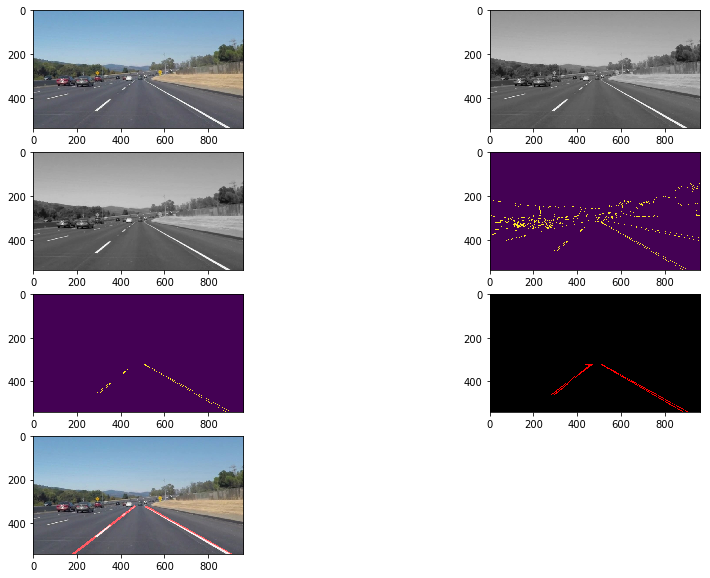

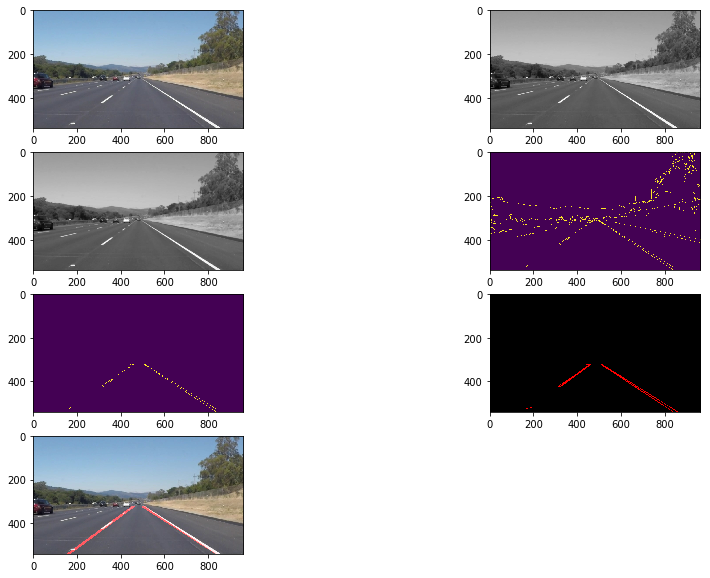

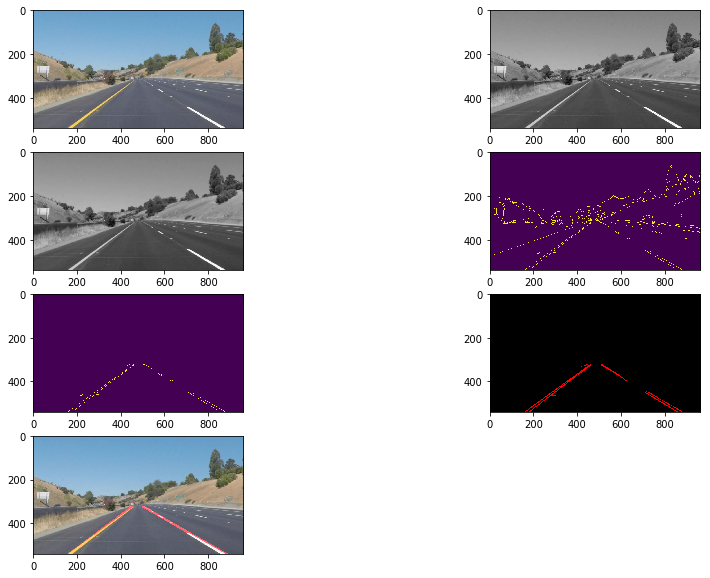

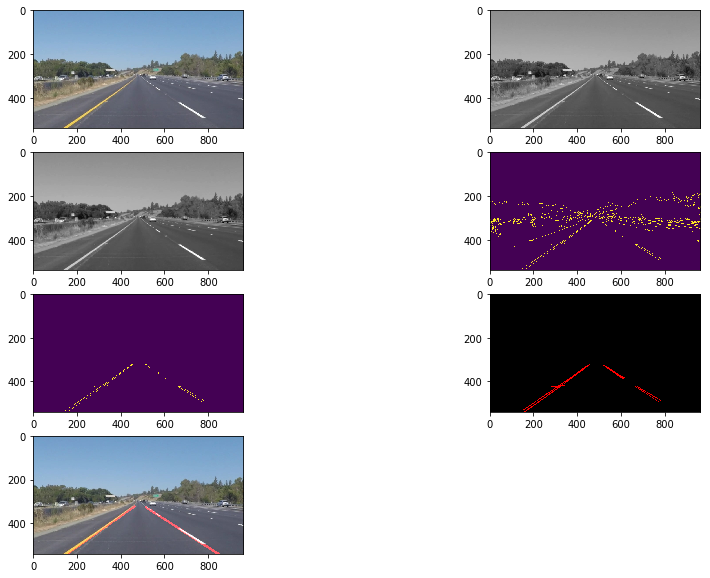

In [30]:
# Set up parameters:    
k_size = 3
vertex_ratio_h = .45
vertex_ratio_v = .6
low_thresh = 50
high_thresh = 150
L2gradient = False
rho = 2
theta = 1 * np.pi / 180.
min_votes = 15
min_line_len = 20
max_line_gap = 30
angle = 33 * np.pi / 180
angle_threshold = 10 * np.pi / 180
line_avg_num = 1  # No dampening for still images

LINES_Q = initialize_queue(x_max, y_max, vertex_ratio_h, vertex_ratio_v,
                           angle)

# Loop through files in the test_images directory:
for f in files:
    plt.figure(figsize = (15, 10))
    image = mpimg.imread('test_images/'+ f)

    ## Display original image combined with extended lines:
    
    combined = lane_detection_ppline(image, 
                                     vertex_ratio_h = vertex_ratio_h,
                                     vertex_ratio_v = vertex_ratio_v,
                                     k_size = k_size,
                                     low_thresh = low_thresh,
                                     high_thresh = high_thresh,
                                     L2gradient = L2gradient,
                                     rho = rho,
                                     theta = theta,
                                     min_votes = min_votes,
                                     min_line_len = min_line_len,
                                     max_line_gap = max_line_gap,
                                     angle = angle,
                                     angle_thresh = angle_threshold,
                                     line_avg_num = line_avg_num,
                                     debug = True)  
    plt.imshow(combined)


After some parameter tuning, the pipeline works flawlessly and correctly identifies and extends lines in each of the images.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [31]:
# Set up parameters:    
k_size = 3
vertex_ratio_h = .45
vertex_ratio_v = .60
low_thresh = 50
high_thresh = 200
L2gradient = False
rho = 2
theta = 1 * np.pi / 180.
min_votes = 15
min_line_len = 40
max_line_gap = 20
angle = 33 * np.pi / 180
angle_threshold = 7 * np.pi / 180
line_avg_num = 5  # Average line positions over the last 5 frames
debug = False

LINES_Q = initialize_queue(x_max, y_max, vertex_ratio_h, vertex_ratio_v,
                           angle)

def process_image(image, 
                  k_size = 3,
                  low_thresh = 50,
                  high_thresh = 150,
                  L2gradient = False,
                  rho = 2,
                  theta = 1 * np.pi/180,
                  min_votes = 15,
                  min_line_len = 40,
                  max_line_gap = 20,
                  angle = 3 * np.pi / 16,
                  angle_thresh = 1 * np.pi / 16,
                  line_avg_num = 5,
                  debug = False):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = lane_detection_ppline(image, 
                                   k_size = k_size,
                                   low_thresh = low_thresh,
                                   high_thresh = high_thresh,
                                   L2gradient = L2gradient,
                                   rho = rho,
                                   theta = theta,
                                   min_votes = min_votes,
                                   min_line_len = min_line_len,
                                   max_line_gap = max_line_gap,
                                   angle = angle,
                                   angle_thresh = angle_threshold,
                                   line_avg_num = line_avg_num,
                                   debug = debug)
    return result

Let's try the one with the solid white lane on the right first ...

In [32]:

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
%time white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


Wall time: 7 ms
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:03<00:00, 55.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 4.47 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Again, the lines are correctly detected and we avoid having to much jitter through the use of time-dampening.

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [34]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:15<00:00, 44.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 15.8 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

**My reflections:**

The above clips show that this pipeline works well in situations where the road is straight or nearly straight (motorways, typically) and lane lines are well-defined. But the challenge video show that it has some serious limitations:

 - What would happen in sub-optimal lighting or visibility conditions (eg. rain, reflections on the road, fog...)?
 - What about sharp turns?
 - What about branching roads or junctions, with diverging lines?
 - How to handle lane changes?
 - Is the pipeline fast enough to process data in real-time, many times per second? Currently, the timers below each of the videos show that the wall time is about 50% of the clip duration, ie. we can process 2 frames per second. This seems insufficient, however an analysis of the timer output show that the vast majority of that time is spent building and writing the edited video file to disk. Skipping that step brings the processing time down to just a few milliseconds. In a real-time application, I expect the actual processing time to be somewhere between these two extremes.
 - In real-life conditions, the cameras can be obstructed by dirt, bugs, snow etc. How do we then ensure that these are not mistaken for lines?
 
To solve some or all of the issues aboves, I can think of the following improvements:

 - Do not convert images to grayscale, instead use differences in all three channels to detect lines.
 - Whenever lines are not found, use the latest computed line position. If this happens on the very first frame, use an approximate line location based on the expected angle entered by the user.
 - For non-straight roads, use variants of the Hough transform algorithm that can detect curves of varying radii.
 - In relation to the issue over obstructed cameras, one solution would be to use a pair of cameras and compare their inputs to detect significant discrepancies.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.

** Not yet, there is still the...**


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [35]:
# Load the clip file
clip2 = VideoFileClip('challenge.mp4')

We will begin by adjusting parameters to try and improve the detection on a sample of frames from the challenge clip:

In [36]:
# Remember to empty the 'challenge' directory before running this cell.

def frange(start, stop, step = 1.):
    ''' 
    Convenience function to create a sequence of floats between 
    two values.
    '''
    i = start
    while i < stop:
        yield i
        i += step

# Extract frames at 0.5s intervals -- the clip is 10s long
for ts in frange(3., 7.5, .5):
    clip2.save_frame("challenge/frame_" + str(ts) + ".jpg", t = ts)

files = os.listdir("challenge/")

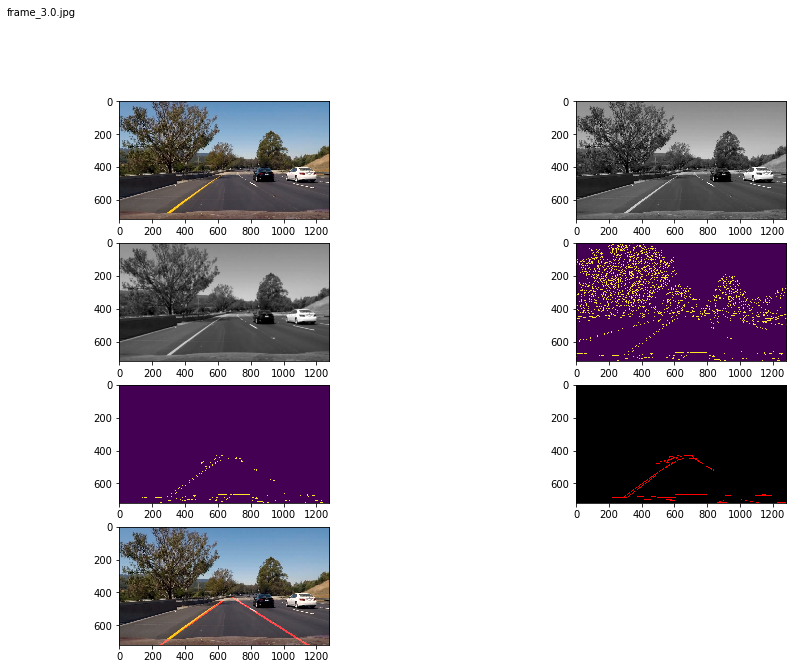

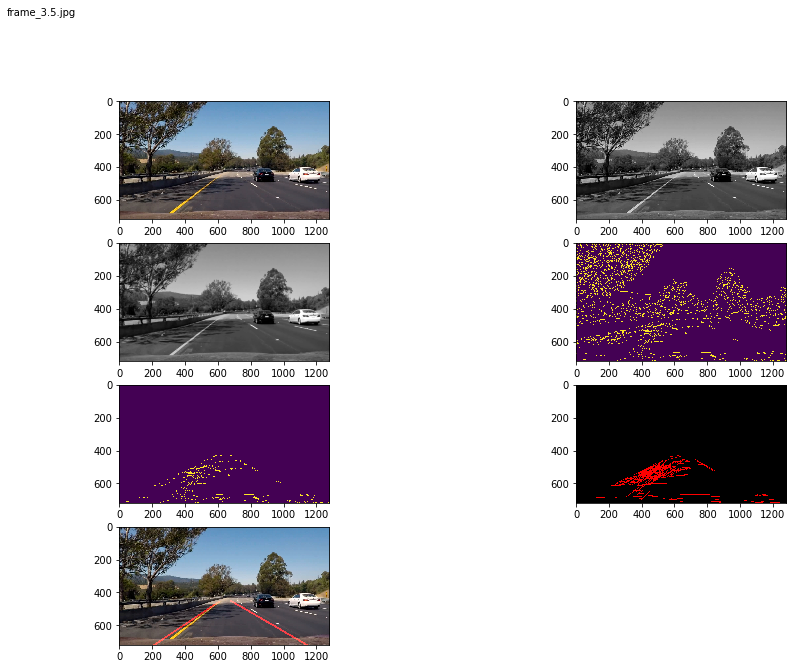

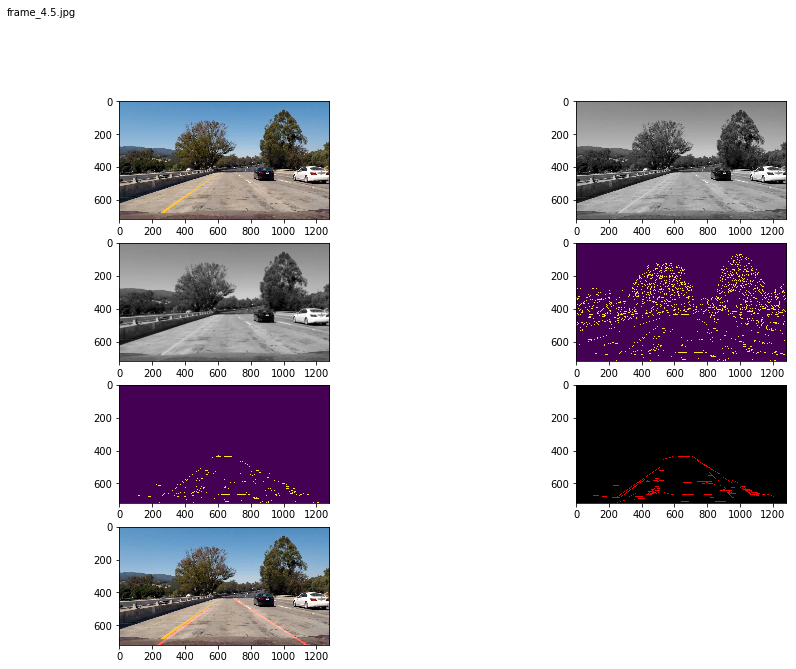

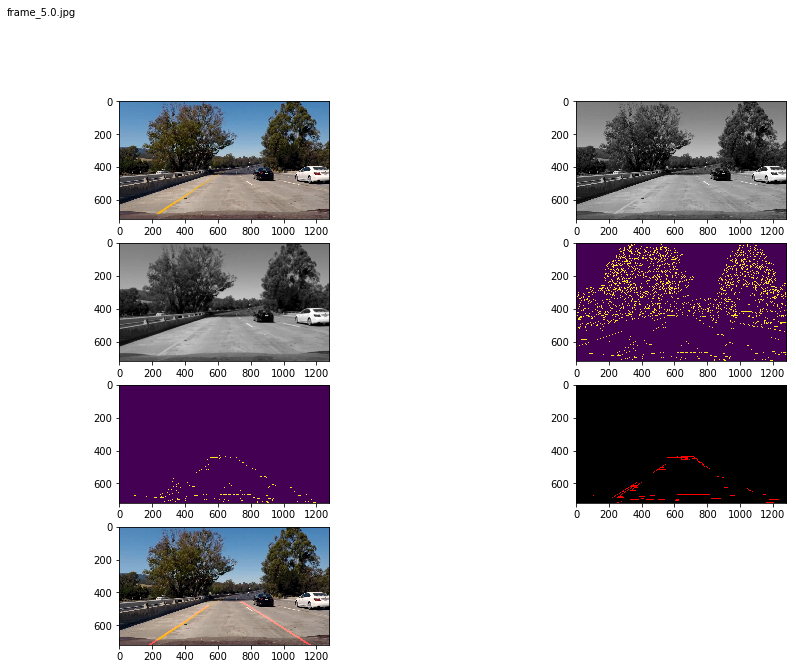

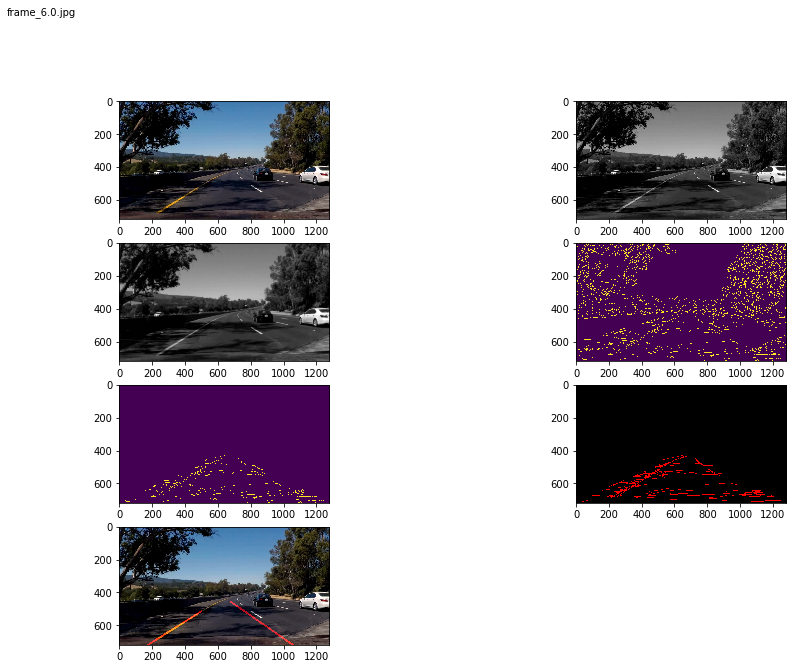

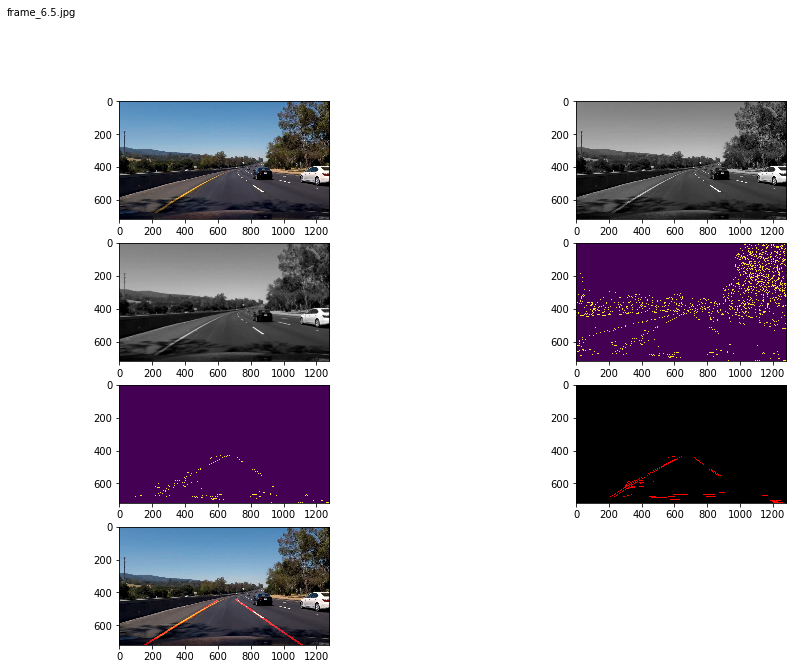

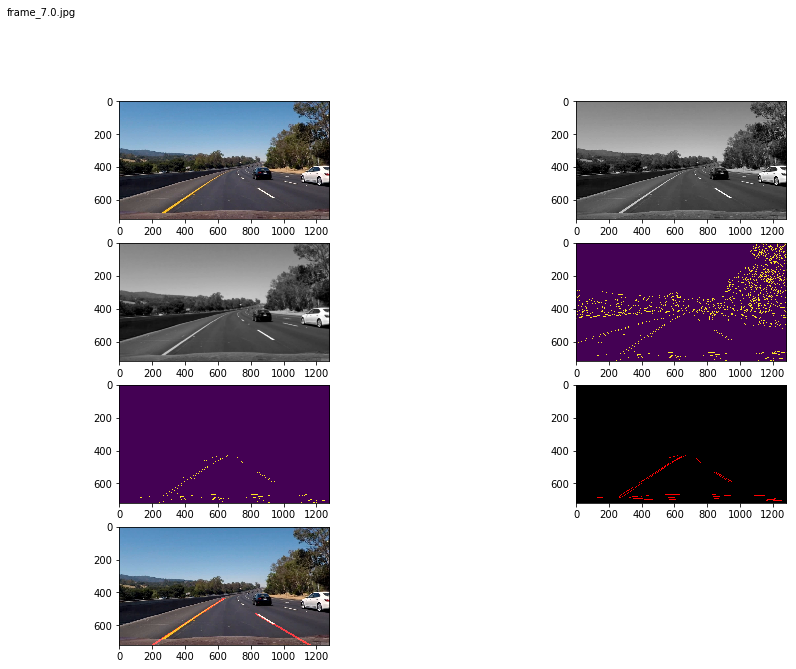

In [37]:
# Set up parameters:    

k_size = 9  # Must be an odd number
vertex_ratio_h = .50
vertex_ratio_v = .75
low_thresh = 15
high_thresh = 50
L2gradient = False
rho = 2
theta = 1 * np.pi / 180.
min_votes = 15
min_line_len = 40
max_line_gap = 20
angle = 33 * np.pi / 180
angle_threshold = 5 * np.pi / 180
line_avg_num = 1  # Disable time-dampening for this test, as we are dealing with still frames
debug = True

LINES_Q = initialize_queue(x_max, y_max, vertex_ratio_h, vertex_ratio_v,
                           angle)

for file in files:
    frame = mpimg.imread('challenge/' + file)
    fig = plt.figure(figsize = (15, 10))
    fig.text(.1, 1, file)
    result = process_image(frame, 
                           k_size = k_size,
                           low_thresh = low_thresh,
                           high_thresh = high_thresh,
                           L2gradient = L2gradient,
                           rho = rho,
                           theta = theta,
                           min_votes = min_votes,
                           min_line_len = min_line_len,
                           max_line_gap = max_line_gap,
                           angle = angle,
                           angle_thresh = angle_threshold,
                           line_avg_num = line_avg_num,
                           debug = debug) 

This seems to work fairly well on a sample of images from the 'challenge' video clip, but we notice that on some of the frames the lines drawn do not follow the actual lines on the road, especially when the road is in the shade (shadows from trees seem to be confused with lines - see `frame_4.5.jpg`). Increasing the Gaussian kernel size seems to help a lot.

However my initial attempt with the challenge video clip crashed, as the Hough transform was unable to find lines in several of the frames.

Let's try a new idea:

### Pipeline v2: HSL channels

Rather than converting the image to greyscale, I want to try converting it to HLS and keeping all three channels to perform the Canny edge detection. One the edges are found, I merge the three channels using weights (another parameter).

To do this we define some new functions:

In [39]:
def rbg_to_hls(img):
    ''' 
    Takes an RGB image and converts it to HLS.
    Returns the converted image (3 channels)
    '''
    hls_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return hls_image

def merge_channels(images, w_1 = 1., w_2 = 1., w_3 = 1.):
    '''
    Merge images from three different channels
     - images: a list of 3 images, each in a channel
    '''
    merged = weighted_img(images[0], images[1], α = w_1, β = w_2, λ = 0.)        
    merged = weighted_img(merged, images[2], α = 1., β = w_3, λ = 0.)
    return merged


def lane_detection_ppline_3_channels(image, 
                                     k_size = 3,
                                     vertex_ratio_h = .45,
                                     vertex_ratio_v = 0.60,
                                     low_thresh = 50,
                                     high_thresh = 200,
                                     L2gradient = False,
                                     weight_h = 0.5,
                                     weight_l = 1.,
                                     weight_s = 1.,
                                     rho = 2,
                                     theta = 1 * np.pi / 180.,
                                     min_votes = 15,
                                     min_line_len = 40,
                                     max_line_gap = 20,
                                     angle = 3 * np.pi / 16,
                                     angle_thresh = np.pi / 16,
                                     line_avg_num = 5,
                                     debug = False):
    '''
    Takes an image and parameters and applies the lane detection pipeline in its
    3-channel version.
    Returns an image combining the original and the extended lines detected
    by the algorithm.
     - image: Original image to perform line detection on
     - k_size: Gaussian kernel size
     - vertex_ratio_h: x-position of the top left-hand side vertex for the ROI, in 
            proportion to the total width of the image. The top right-
            hand side vertex is located at (1 - vertex_ratio_x) * width
     - vertex_ratio_v: y-position of the two top vertices for the ROI.
     - low_thresh: Lower threshold for Canny edge detection.
     - high_thresh: Higher threshold for Canny edge detection.
     - L2gradient: Use L2-norm rather than L1 in Canny edge detection.
     - weight_h: Weight of the H-channel output of Canny edge detection.
     - weight_l: Weight of the L-channel output of Canny edge detection.
     - weight_s: Weight of the S-channel output of Canny edge detection.
     - rho: Grid linear resolution in Hough space, radial direction.
     - theta: Grid angle resolution in Hough space, polar direction.
     - min_votes: Minimum number of aligned points required to declare a straight line 
     - min_line_len: Minimum length required for a series of aligned points to be
            declared a straight line.
     - max_line_gap: Maximum gap allowed between two segments for them to be 
            considered a single straight line.
     - angle: Approximate angle that left-hand lines are expected to make with the 
            horizontal. For right-hand lanes, the function uses pi - angle.
     - angle_thresh: The function will look for lines are angle +/- angle_thresh. 
            Lines outside this range will be rejected (pi - angle +/- angke thresh for
            right-hand lines).
     - line_avg_num: Number of successive frames to average the line positions over. 
            When processing a video clip, this helps reduce jitter. Use 1 if no
            averaging is required.
     - debug: Whether or not to display the images after each step of the process, for
            debugging or tuning purposes.
    '''
    max_y, max_x = image.shape[:2]  # Grab image dimensions
    # Define 4-sided polygon in relation to image dimensions:
    roi = np.array([[(0, max_y), 
                  (round(max_x * vertex_ratio_h), round(max_y * vertex_ratio_v)),
                  (round(max_x * (1 - vertex_ratio_h)), round(max_y * vertex_ratio_v)),
                  (max_x, max_y)]])
    if debug:
        plt.subplot(5, 3, 1)
        plt.imshow(image)
    
    ## 1. Gaussian smoothing with custom parameters ##
    blur = gaussian_blur(image, k_size)
    if debug:
        plt.subplot(5, 3, 2)
        plt.imshow(blur)
    
    ## 2. Conversion to HLS ##
    hls = rbg_to_hls(blur)
    if debug:
        plt.subplot(5, 3, 3)
        plt.imshow(hls)
    
    ## 3. Canny filter on all 3 channels ##
    edges_list = []
    for chan in range(0, 3):
        edges_list.append(canny(hls[:, :, chan], low_thresh, high_thresh, L2gradient = L2gradient))
        if debug:
            plt.subplot(5, 3, chan + 4)
            plt.imshow(edges_list[chan])
    
    ## 4. Mask for Region of interest ##
    masked_edges_list = []
    for chan in range(0, 3):
        masked_edges_list.append(region_of_interest(edges_list[chan], roi))
        if debug:
            plt.subplot(5, 3, chan + 7)
            plt.imshow(masked_edges_list[chan])
    
    ## 5. Combine outputs from Canny filter
    combined_edges = merge_channels([masked_edges_list[0], 
                                     masked_edges_list[1], 
                                     masked_edges_list[2]], 
                                    w_1 = weight_h, w_2 = weight_l, w_3 = weight_s)
    if debug:
        plt.subplot(5, 3, 10)
        plt.imshow(combined_edges)
        
    ## 6. Hough transform ##
    line_img, lines = hough_lines(combined_edges, rho, theta, min_votes, min_line_len, max_line_gap)
    if debug:
        plt.subplot(5, 3, 11)
        plt.imshow(line_img)
    
    ## 7. Extend lines and create the combined image ##
    combined = extend_lines(image, lines, angle = angle, angle_thresh = angle_thresh,
                            line_avg_num = line_avg_num)
    if debug:
        plt.subplot(5, 3, 12)
        plt.imshow(combined)
    return combined


def process_image_3_channels(image, 
                  k_size = 3,
                  vertex_ratio_h = .45,
                  vertex_ratio_v = 0.60,
                  low_thresh = 50,
                  high_thresh = 200,
                  L2gradient = False,
                  weight_h = 0.5,
                  weight_l = 1.,
                  weight_s = 1.,
                  rho = 2,
                  theta = 1 * np.pi / 180.,
                  min_votes = 15,
                  min_line_len = 40,
                  max_line_gap = 20,
                  angle = 3 * np.pi / 16,
                  angle_thresh = np.pi / 16,
                  line_avg_num = 5,         
                  debug = False):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = lane_detection_ppline_3_channels(image, 
                                   k_size = k_size,
                                   low_thresh = low_thresh,
                                   high_thresh = high_thresh,
                                   L2gradient = L2gradient,
                                   weight_h = weight_h,
                                   weight_l = weight_l,
                                   weight_s = weight_s,           
                                   rho = rho,
                                   theta = theta,
                                   min_votes = min_votes,
                                   min_line_len = min_line_len,
                                   max_line_gap = max_line_gap,
                                   angle = angle,
                                   angle_thresh = angle_threshold,
                                   line_avg_num = line_avg_num, 
                                   debug = debug)
    return result

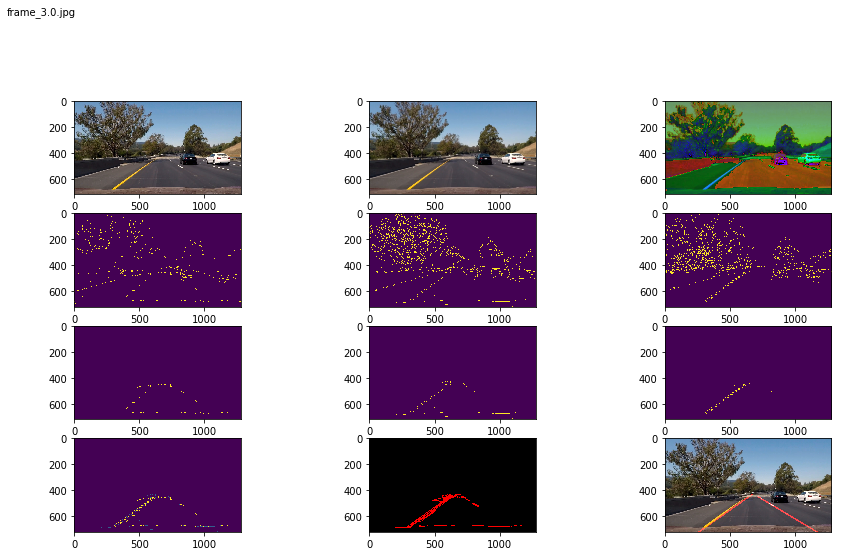

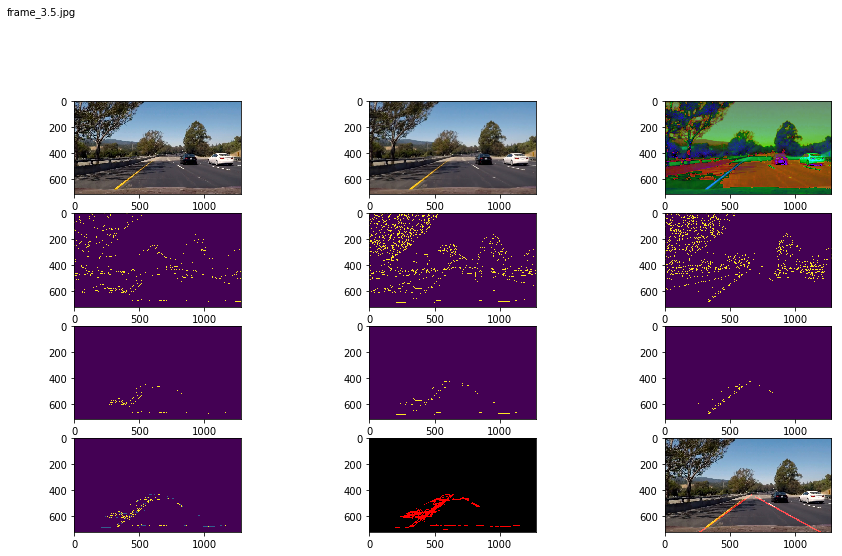

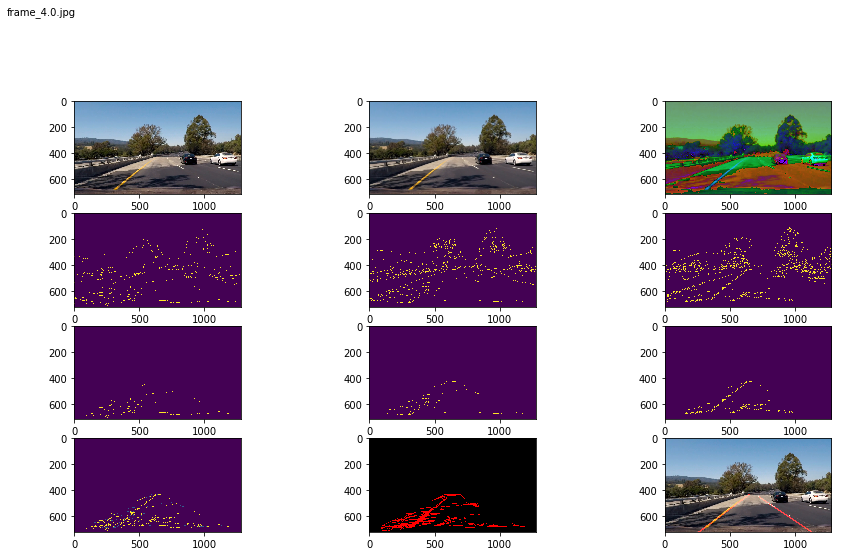

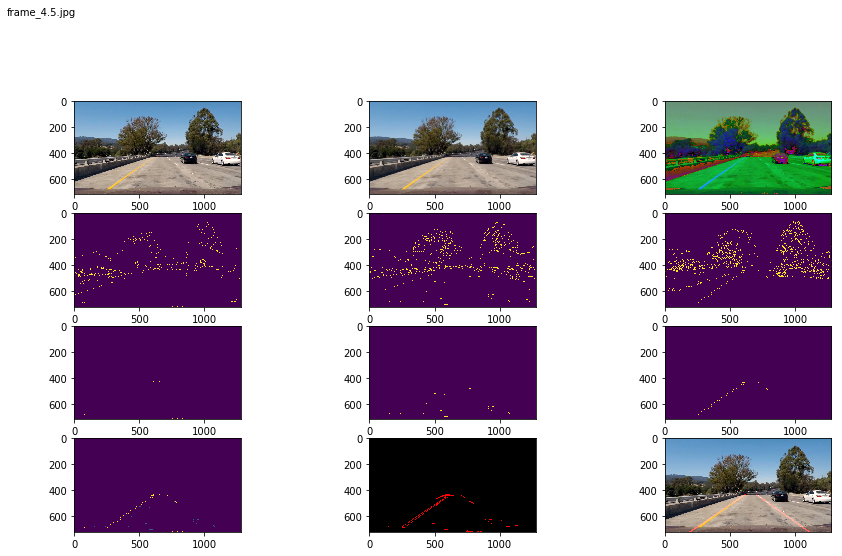

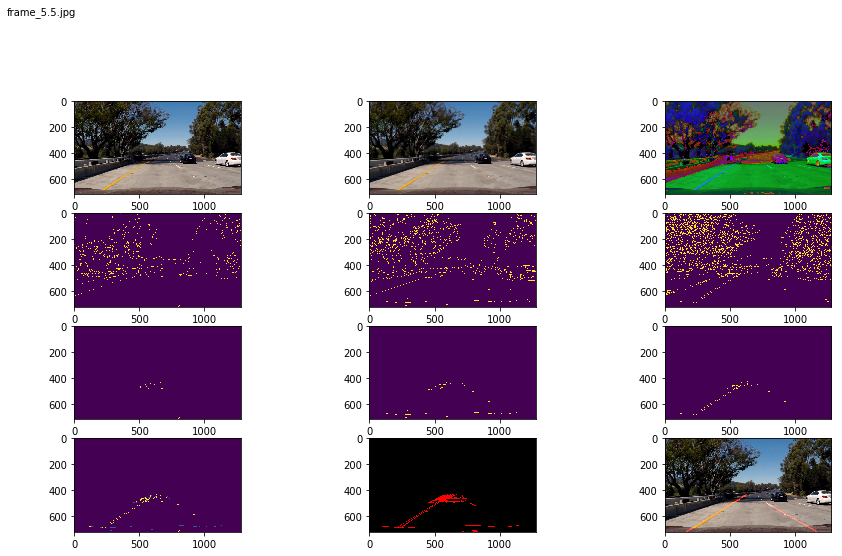

In [40]:
files = os.listdir("challenge/")
#test_image = plt.imread("challenge/frame_4.0.jpg")
#test_image = plt.imread("test_images/solidWhiteCurve.jpg")

# Parameters:

k_size = 7
vertex_ratio_h = .45
vertex_ratio_v = 0.60
low_thresh = 60
high_thresh = 100
L2gradient = False
weight_h = .3
weight_l = 1.
weight_s = 1.
rho = 2
theta = 1 * np.pi / 180.
min_votes = 20
min_line_len = 30
max_line_gap = 20
angle = 33 * np.pi / 180
angle_threshold = 6 * np.pi / 180
line_avg_num = 1
debug = True

LINES_Q = initialize_queue(x_max, y_max, vertex_ratio_h, vertex_ratio_v,
                           angle)

for file in files:
    frame = mpimg.imread('challenge/' + file)
    fig = plt.figure(figsize = (15, 10))
    fig.text(.1, 1, file)
    result = process_image_3_channels(frame, 
                           k_size = k_size,
                           low_thresh = low_thresh,
                           high_thresh = high_thresh,
                           L2gradient = L2gradient,
                           weight_h = weight_h,
                           weight_l = weight_l,
                           weight_s = weight_s,           
                           rho = rho,
                           theta = theta,
                           min_votes = min_votes,
                           min_line_len = min_line_len,
                           max_line_gap = max_line_gap,
                           angle = angle,
                           angle_thresh = angle_threshold,
                           line_avg_num = line_avg_num,           
                           debug = debug) 

Using this new pipeline seems to improve things when lighting conditions are difficult. Accuracy is good overall, the only exception being `frame_6.0.jpg`, where the right-hand line diverges to the left.

In [41]:
challenge_output = 'extra.mp4'

# Parameters:

k_size = 9
vertex_ratio_h = .48
vertex_ratio_v = 0.75
low_thresh = 60
high_thresh = 100
L2gradient = False
weight_h = 0.
weight_l = 1.
weight_s = 1.
rho = 2
theta = 2 * np.pi / 180.
min_votes = 20
min_line_len = 25
max_line_gap = 20
angle = 33 * np.pi / 180
angle_threshold = 5 * np.pi / 180
line_avg_num = 10
debug = False

LINES_Q = initialize_queue(x_max, y_max, vertex_ratio_h, vertex_ratio_v,
                           angle)

challenge_clip = clip2.fl_image(lambda x: process_image_3_channels(x,
                                                        k_size = k_size,
                                                        low_thresh = low_thresh,
                                                        high_thresh = high_thresh,
                                                        L2gradient = L2gradient,
                                                        weight_h = weight_h,
                                                        weight_l = weight_l,
                                                        weight_s = weight_s, 
                                                        rho = rho,
                                                        theta = theta,
                                                        min_votes = min_votes,
                                                        min_line_len = min_line_len,
                                                        max_line_gap = max_line_gap,
                                                        angle = angle,
                                                        angle_thresh = angle_threshold,
                                                        line_avg_num = line_avg_num,           
                                                        debug = debug))
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:12<00:00, 20.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 13.4 s


In [42]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

With these improvements, the challenge video can now be processed mostly accurately. There are a couple of issues left:

 - Still some confusion between lines and tree shadows
 - Slightly imprecise left-hand line position in the later part of the video, where the road turns significantly to the right.
 
These limitations are unlikely to be lifted just by tweaking parameters -- which I did at length -- and would probably require more advanced models.